# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям 

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [2]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import tqdm
import copy
import torch.optim as optim

## Загрузка данных

In [2]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [3]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


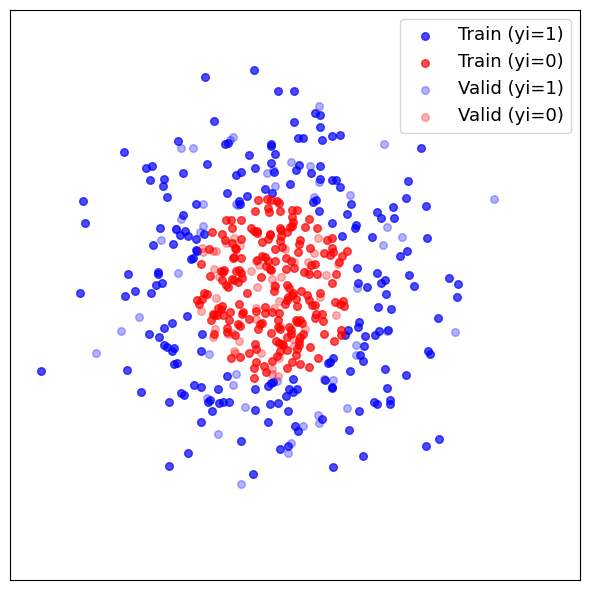

In [4]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть 

In [5]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
                        
    def forward(self, x):
        return self.layers(x)
    

##  Функция обучения сети

In [7]:
def start_train(
        model,      # model to train
        loss_fn,    # loss func
        opt,        # optimizer
        n_epochs,   # number of epochs 
        batch_size, # size of each batch
        X_train,    # train features
        y_train,    # train predictions
        X_val=None, # test features
        y_val=None, # test predictions
    ):
    
    # data_loader = DataLoader(dataset = TensorDataset(X_train, y_train), batch_size = batch_size)

    # x_val_ld = DataLoader(dataset = X_val, batch_size = 1) if X_val != None else None
    # y_val_ld = DataLoader(dataset = y_val, batch_size = 1) if y_val != None else None

    batch_start = torch.arange(start=0, end=len(X_train), step=batch_size)

    optimizer = opt
    
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    preds_history = []
    loss_history = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            # for x, y in data_loader:
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch.reshape(batch_size, 1))
                loss_history.append(loss.item())

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update weights
                optimizer.step()
                
                # print progress
                acc = (y_pred.round() == y_batch.reshape(batch_size, 1)).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )    
    
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        
        if (epoch % 2 == 0):
            preds = np.where(model(X_val).detach().numpy().reshape(-1) > 0.5, 1, 0)
            preds_history.append(preds)
        
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return loss_history, preds_history

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [15]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

model_sgd_opt = NeuralNetwork()
model_adam_opt = NeuralNetwork()
model_rmsprop_opt = NeuralNetwork()

configurations = {
    'SGD': {
        'learning_rate': 0.3,
        'model': model_sgd_opt,
        'opt': optim.SGD,
    },
    'Adam': {
        'learning_rate': 0.1,
        'model': model_adam_opt,
        'opt': optim.Adam,
    },
    'RMSprop': {
        'learning_rate': 0.5,
        'model': model_rmsprop_opt,
        'opt': optim.RMSprop,
    }
}

result = {
    'SGD': {
        'loss_history': [],
        'predict_history': []
    },
    'Adam': {
        'loss_history': [],
        'predict_history': []
    },
    'RMSprop': {
        'loss_history': [],
        'predict_history': []
    },
}

for conf_name, conf in configurations.items():
    print(conf_name)
    
    model = conf['model']
    optimizer = conf['opt'](model.parameters(), lr=0.3)
    
    loss_history, predict_history = start_train(
        model=model, 
        loss_fn=nn.BCELoss(), 
        opt=optimizer, 
        n_epochs=100, 
        batch_size=16,
        X_train=X_train_torch,
        y_train=y_train_torch,
        X_val=X_valid_torch, 
        y_val=y_valid_torch
    )
    
    result[conf_name]['loss_history'] = loss_history
    result[conf_name]['predict_history'] = predict_history


SGD


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 625.00batch/s, acc=1, loss=0.0278]    


Adam


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 568.17batch/s, acc=1, loss=0.000106]  


RMSprop


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 555.56batch/s, acc=1, loss=2.41e-7]   


### А теперь посмотрим на графики лоссов

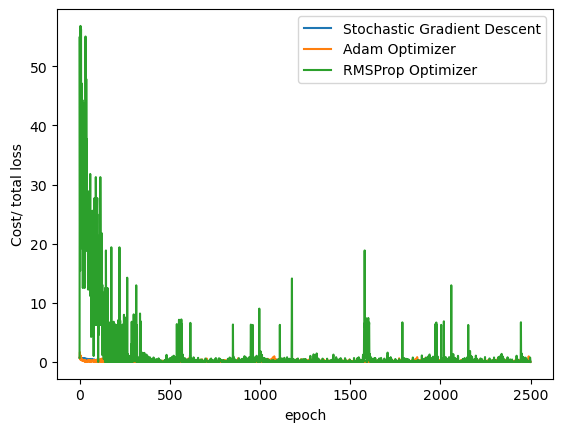

In [22]:
plt.plot(result['SGD']['loss_history'], label = "Stochastic Gradient Descent")
plt.plot(result['Adam']['loss_history'], label = "Adam Optimizer")
plt.plot(result['RMSprop']['loss_history'], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()


### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните результат

In [48]:
from enum import Enum

class InitType(Enum):
    Random = 1
    Xavier = 2

class Net(nn.Module):
    def __init__(self, init_type: InitType) -> None:
        super(Net, self).__init__()
        
        self.layer_1 = nn.Linear(2, 32)
        self.act_1 = nn.LeakyReLU()
        
        self.out = nn.Linear(32, 1)
        self.sig = nn.Sigmoid()
        
        if init_type == InitType.Random:
            nn.init.normal_(self.layer_1.weight, mean=0, std=0.01)
            nn.init.normal_(self.layer_1.bias, mean=0, std=0.01)
            
            nn.init.normal_(self.out.weight, mean=0, std=0.01)
            nn.init.normal_(self.out.bias, mean=0, std=0.01)
        elif init_type == InitType.Xavier:
            nn.init.xavier_normal_(self.layer_1.weight)
            nn.init.zeros_(self.layer_1.bias)
            
            nn.init.xavier_normal_(self.out.weight)
            nn.init.zeros_(self.out.bias)
        
    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.sig(self.out(x))
        return x     

In [58]:
result = {}

for init_type in [InitType.Random, InitType.Xavier]:
    print(init_type)
    
    model = Net(init_type=init_type)
    optimizer = optim.SGD(model.parameters(), lr = 0.1)

    loss_history, _ = start_train(
            model=model, 
            loss_fn=nn.BCELoss(), 
            opt=optimizer, 
            n_epochs=100, 
            batch_size=16,
            X_train=X_train_torch,
            y_train=y_train_torch,
            X_val=X_valid_torch, 
            y_val=y_valid_torch
        )
    
    result[init_type] = loss_history


InitType.Random


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 454.55batch/s, acc=1, loss=0.0686]   


InitType.Xavier


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 694.48batch/s, acc=1, loss=0.0666]   


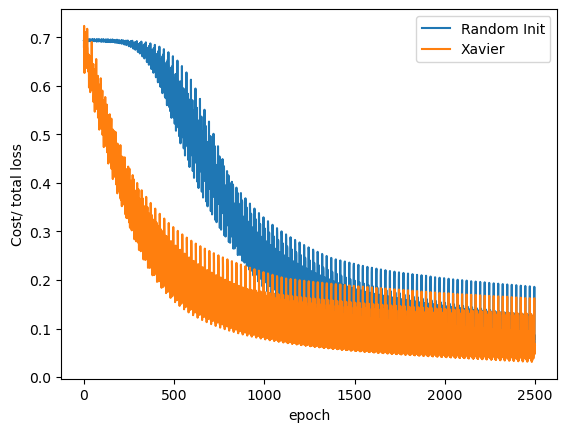

In [59]:
plt.plot(result[InitType.Random], label = "Random Init")
plt.plot(result[InitType.Xavier], label = "Xavier")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

Найдите лучшие параметры через KFold

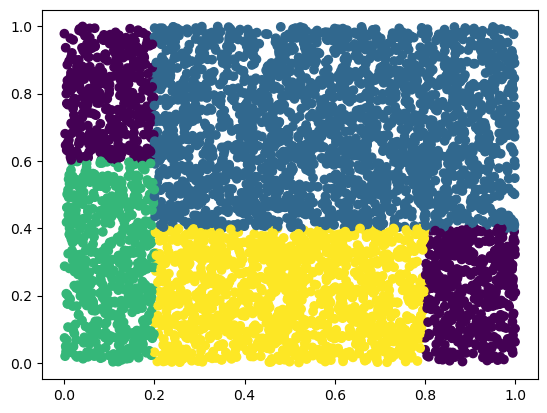

In [5]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)
        
target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [4]:
train

tensor([[0.8099, 0.1186, 0.0000],
        [0.6313, 0.8004, 1.0000],
        [0.7700, 0.6753, 1.0000],
        ...,
        [0.2416, 0.1706, 3.0000],
        [0.9639, 0.6826, 1.0000],
        [0.6791, 0.9508, 1.0000]])

In [54]:
class AdvancedModel(nn.Module):   
    def __init__(self,):
        super(AdvancedModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 4),
            # nn.Linear(2, 25),
            # nn.Sigmoid(),
            # nn.Linear(25, 4),
            # nn.Sigmoid()
        )
        
        for param in self.layers:
            self.init_parameter(param)
            
    def init_parameter(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.zeros_(module.bias)    
    
    def forward(self, x):
        return self.layers(x) 
        

In [37]:
# one hot example
labels=torch.Tensor([[0, 2, 1]]).long()
n_classes=3
indicies = torch.nn.functional.one_hot(labels, n_classes)
test_pred = torch.Tensor([[[0.99, 0, 0], [0,0,0.8], [0,0,0]]])

loss_fn = nn.CrossEntropyLoss()

loss_fn(test_pred.float(), indicies.float())


tensor(0.7652)

In [7]:
def train_model(
    model,      # model to train
    optim,      # optimizer
    loss_fn,    # loss function
    n_epochs,   # number of epochs 
    batch_size, # size of each batch
    X_train,    # train features
    y_train,    # train predictions
    X_val,      # test features
    y_val,      # test predictions
):
    # if torch.cuda.is_available():
    #     X_val, y_val = X_val.cuda(), y_val.cuda()
    
    # datasets
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_val, y_val)
    # getting DataLoader 
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)
    
    optimizer = optim
    
    preds_history = []
    loss_history = []
    valid_loss_history = []
    
    best_acc = - np.inf
    best_weights = []
    
    # bar = tqdm.tqdm(train_loader, unit="batch", mininterval=0, disable=False)

    total_correct = 0
    total_instances = 0
    
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(train_loader, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x_train, y_train in bar:
                
                # if torch.cuda.is_available():
                #     x_train, y_train = x_train.cuda(), y_train.cuda()

                bar.set_description(f'Epoch {epoch}')
            
                # y_train = nn.functional.one_hot(y_train.long(), num_classes = 4).float()

                # forward
                y_pred = model(x_train)

                # y_pred.requires_grad = True
                # y_train.requires_grad = True

                # assert y_pred.size() == y_train.size(), f"y_pred.size(): {y_pred.size()} y_train.size(): {y_train.size()}"

                y_train = y_train.type(torch.LongTensor)            
                loss = loss_fn(y_pred, y_train)
                loss_history.append(loss.item())

                optimizer.zero_grad()   # clear the gradients
                loss.backward() # backward pass

                # update weights
                optimizer.step()
                
                correct_predictions = sum(torch.argmax(y_pred, dim=1) == y_train).item()
                total_correct+=correct_predictions
                total_instances+=len(x_train)
                
                # acc = (y_pred.round() == y_train).float().mean()
                acc = round(total_correct/total_instances, 3)

                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

            for x_valid, y_valid in valid_loader:

                # if torch.cuda.is_available():
                #     x_valid, y_valid = x_valid.cuda(), y_valid.cuda()

                # y_valid = nn.functional.one_hot(y_valid.long(), num_classes = 4).float()

                # y_valid_pred = torch.argmax(model(x_valid), dim=1).float()
                y_valid = y_valid.type(torch.LongTensor)
                y_valid_pred = model(x_valid)

                valid_loss = loss_fn(y_valid_pred, y_valid)
                valid_loss_history.append(valid_loss.item())
                
            
        model.eval()
        y_pred = model(X_val)
        # y_val_encoded = nn.functional.one_hot(y_val.long(), num_classes = 4).float()
        # if (epoch % 2 == 0):
            # preds = np.where(model(X_val).detach().numpy().reshape(-1) > 0.5, 1, 0)
            # preds_history.append(preds)
        
        # if (epoch % 2 == 0):
        #     preds = np.where(model(X_val).detach().numpy().reshape(-1) > 0.5, 1, 0)
        #     preds_history.append(preds)
        
        acc = (torch.argmax(y_pred, dim=1) == y_val).float().mean()
        acc = float(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break
        
    model.load_state_dict(best_weights)
    return loss_history, preds_history, valid_loss_history
        

In [55]:
advanced_model = AdvancedModel()

# if torch.cuda.is_available():
#     advanced_model = advanced_model.cuda()
    
opt = optim.Adam(advanced_model.parameters(), lr=0.001)

lh, ph, vlh = train_model(
    model=advanced_model,
    optim=opt,
    loss_fn=nn.CrossEntropyLoss(),
    n_epochs=500,
    batch_size=32,
    X_train=train[:,:2],
    y_train=train[:, 2],
    X_val=valid[:, :2],
    y_val=valid[:, 2]

)



Epoch 293: 100%|██████████| 25/25 [00:00<00:00, 382.71batch/s, acc=0.959, loss=0.0245]


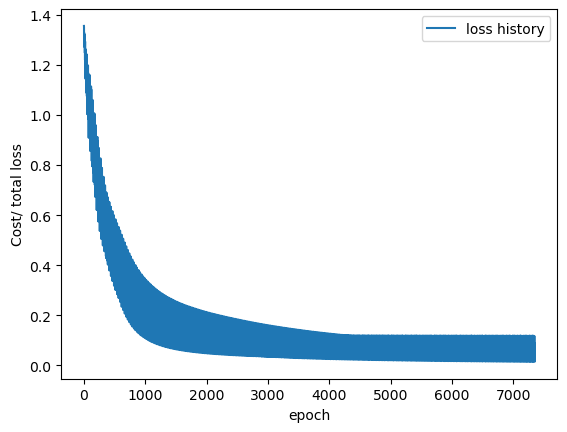

In [59]:
plt.plot(lh, label = "loss history")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

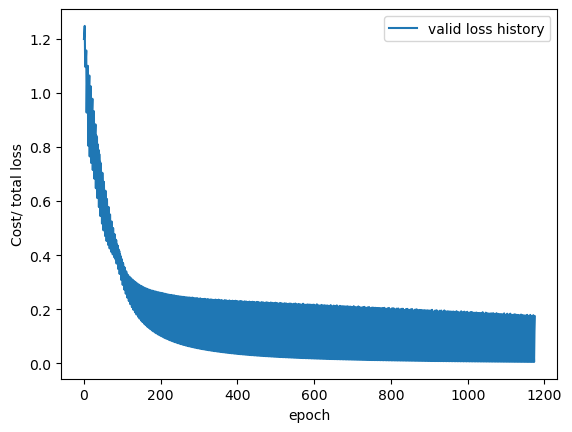

In [61]:
plt.plot(vlh, label = "valid loss history")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## (Почти) Боевая задача
 
Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [7]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.tail()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840.0,2
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560.0,2


In [8]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [9]:
X_train, y_train = df_train.drop(['target'], axis=1), df['target']
X_val, y_val = df_val.drop(['target'], axis=1), df['target']


In [12]:
X_train_ts = torch.FloatTensor(X_train.values)
X_val_ts = torch.FloatTensor(X_val.values)

y_train_ts = torch.LongTensor(y_train.values)
y_val_ts = torch.LongTensor(y_val.values)

In [13]:
df['target'].unique()

array([0, 1, 2])